In [224]:
#from multiprocessing import Pool
#from functools import partial
import numpy as np
#from numba import jit

In [225]:
#For regression, boston dataset
from sklearn import datasets
boston = datasets.load_boston()
X = boston.data
y = boston.target

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

/opt/anaconda3/envs/ee511/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing

In [3]:
#california housing dataset
from sklearn.datasets import fetch_california_housing

# Load the full dataset
california_housing = fetch_california_housing()

# Extract the first 1000 samples from the dataset
X = california_housing.data[:1000]
y = california_housing.target[:1000]

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

In [226]:
def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs], idxs

train, target, idxsi = bootstrap_sample(X_train, y_train)


In [227]:
######################working splitting part############################


def find_split_point(train, target, lmda=1, gamma=0.001):
    node =None
    best_feature = None
    best_val = None
    best_gain = 0 # changed to negative infinity
    n = len(target)
    #put m'
    num_featuress = train.shape[1]
    num_features = np.random.choice(num_featuress, size=4,replace=False)  ####modified####
    for feature in num_features:
        feature_values = train[:, feature]
        feature_values_sorted = np.sort(feature_values)
        num_sorted = feature_values_sorted.shape[0]
        thresh = []
        for j in range(num_sorted-1):
            thresh_val = (feature_values_sorted[j] + feature_values_sorted[j+1]) / 2
            thresh.append(thresh_val)
            
        for val in thresh:
            left_child = {'X': [], 'y': []}
            right_child = {'X': [], 'y': []}
            left_indices =  np.where(feature_values<= val)[0]
            right_indices = np.where(feature_values > val)[0]
            
            if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                continue
            left_target=[]
            #left_x = []
            right_target=[]
            #right_x = []
            left_target = target[left_indices]
            left_child['X'] = X[left_indices]
            left_child['y'] = target[left_indices]
            
            right_target = target[right_indices]
            right_child['X'] = X[right_indices]
            right_child['y'] = target[right_indices]
        
            G_left, H_left = compute_loss_derivatives(left_target)
            G_right, H_right = compute_loss_derivatives(right_target)
            gain = ((((G_left**2)/(H_left + lmda)) + ((G_right**2)/(H_right + lmda)) - (((G_left + G_right)**2)/(H_left + H_right + lmda))) / 2) - gamma
            
            if gain > best_gain:
                best_gain = gain
                left_child['X'] = np.array(left_child['X'])
                right_child['X'] = np.array(right_child['X'])
                node = {'gain': gain,
                    'left_child': left_child,
                    'right_child': right_child,
                    'split_point': val,
                    'feature_idx': feature,
                    #'left_indices': left_indices,
                    #'right_indices': right_indices
                       }
            if gain < 0:
                break
    return node       
#    return best_feature, best_val

def compute_g_h(target):
    
    g = -2*abs(target - np.mean(target))
    h = 2*(np.ones_like(target))
    return g,h

def compute_loss_derivatives(target):
    g, h = compute_g_h(target)
    G = np.sum(g)
    H = np.sum(h)
    return G, H

In [228]:
def split_node(node, min_samples_split, max_depth, depth):
    if node is None:
        return
    left_child = node['left_child']
    right_child = node['right_child']
    
    if (left_child == None ):
        del(node['left_child'])
        node['left_split'] = terminal_node(right_child['y'])
    
    if (right_child == None ):
        del(node['right_child'])
        node['right_split'] = terminal_node(left_child['y'])
    
        #del(node['right_child'])
    del(node['left_child'])
    del(node['right_child'])
    
    if len(left_child['y']) == 0 or len(right_child['y']) == 0:
        empty_child = {'y': left_child['y'] + right_child['y']}
        node['left_split'] = terminal_node(empty_child['y'])
        node['right_split'] = terminal_node(empty_child['y'])
        return

    if depth >= max_depth:
        node['left_split'] = terminal_node(left_child['y'])
        node['right_split'] = terminal_node(right_child['y'])
        return node

    if len(left_child['y']) <= min_samples_split:
            node['left_split'] = terminal_node(left_child['y'])
    else:
        left_node = find_split_point(left_child['X'], left_child['y'])
        
        if left_node is None:
            node['left_split'] = terminal_node(left_child['y'])
        else:
            node['left_split'] = left_node
            split_node(node['left_split'], min_samples_split, max_depth, depth+1)

    if len(right_child['y']) <= min_samples_split:
            node['right_split'] = terminal_node(right_child['y'])
    else:
        right_node = find_split_point(right_child['X'], right_child['y'])
        if right_node is None:
            node['right_split'] = terminal_node(right_child['y'])
        else:
            node['right_split'] = right_node
            split_node(node['right_split'], min_samples_split, max_depth, depth+1)
    #print(node)
    return node
    
def terminal_node(target):
    G, H = compute_loss_derivatives(target)
    weight = -G / (H+lmda)
    return weight


In [229]:
def build_tree(train, target, max_depth, min_samples_split):
    root_node = find_split_point(train, target)
    split_node(root_node, min_samples_split, max_depth, 1)
    return root_node

In [230]:
def random_forest(X_train, y_train, tmax, max_depth, min_samples_split):
    tree_ls = list()
    for i in range(tmax):
        train, target, idxsi = bootstrap_sample(X_train, y_train)
        tree = build_tree(train, target, max_depth, min_samples_split)
        tree_ls.append(tree)
    return tree_ls


In [231]:
def predict_tree(tree, X_test):
#     if tree is None:
#         return 
    feature_idx = tree['feature_idx']

    if X_test[feature_idx] <= tree['split_point']:
        if type(tree['left_split']) == dict:
            return predict_tree(tree['left_split'], X_test)
        else:
            value = tree['left_split']
            return value
    else:
        if type(tree['right_split']) == dict:
            return predict_tree(tree['right_split'], X_test)
        else:
            return tree['right_split']

In [232]:
def predict_rf(tree_ls, X_test):
    pred_final = []
    for i in range(len(X_test)):
        pred_ls = 0
        for tree in tree_ls:
            pred = predict_tree(tree, X_test[i])
            pred_ls = pred_ls + pred
        pred_ls = (pred_ls/tmax) + 20
        pred_final.append(pred_ls)
    return pred_final

In [233]:
tmax = 32 # 5 to 50
max_depth = 6 # 2 to 10
min_samples_split = 25 # 1 to 50
lmda = 5 # 0 to 10
gamma = 0.4 # 0 to 1

model = random_forest(X_train, y_train, tmax, max_depth, min_samples_split)


In [234]:
preds = predict_rf(model, X_test)
print(preds)
print(len(preds))
print((y_test))

[26.362615881304826, 26.46359466224107, 26.690095398917602, 26.569793974684714, 24.97550689076381, 25.64915234416339, 26.395950559287247, 27.051135750125198, 26.24701172172778, 26.129378433133972, 25.254886916891508, 25.87515738807322, 26.507550416506806, 25.791256655377353, 23.97005374943618, 26.73505768670433, 26.394359101446284, 26.362615881304826, 26.58989439323108, 25.876825734281326, 26.750005950118663, 24.066968016681045, 25.2314341283196, 26.394359101446284, 26.678963855957505, 25.61884742888276, 24.821633644806347, 25.563752470370513, 25.37639314424129, 26.271576353322185, 26.078971725115878, 26.12289607698302, 26.333954518293268, 26.075946487844227, 25.86326288831544, 26.394359101446284, 24.718092692392943, 26.46359466224107, 26.67730879708917, 25.30673808105463, 26.607594572479787, 26.362615881304826, 25.868865741924104, 26.078971725115878, 24.887161868292946, 25.78171755064599, 26.363178031480388, 26.12289607698302, 25.424529770115697, 25.64915234416339, 26.014549323973313,

In [235]:
def root_mean_square_error(pred, y):
    #TODO
    rmse = np.sqrt((np.sum((y - pred)**2))*(1/len(y)))
    return rmse

rmse = root_mean_square_error(preds, y_test)
print(rmse)

preds_train = predict_rf(model, X_train)

rmse_train = root_mean_square_error(preds_train,y_train)
print("rmse_train: ",rmse_train)

9.435128614914879
rmse_train:  9.815044521788552


In [236]:
################################## GBDT ###########################################

def find_split_point_gbdt(train, target,residual, lmda=0, gamma=0):
    node =None
    best_feature = None
    best_val = None
    best_gain = 0
    num_featuress = train.shape[1]
    num_features = np.random.choice(num_featuress, size=int(0.5*num_featuress),replace=True)
    #for feature in enumerate(selected_features):
    for feature in (num_features):
        feature_values = train[:, feature]
        feature_values_sorted = np.sort(feature_values)
        num_sorted = feature_values_sorted.shape[0]
        thresh = []
        if type(feature_values)==[int, float]:

            for j in range(num_sorted-1):
                thresh_val = (feature_values_sorted[j] + feature_values_sorted[j+1]) / 2
                thresh.append(thresh_val)

        else: 
            for j in range(train.shape[0]):
                thresh.append(feature_values[j])
        for val in thresh:
            left_child = {'X': [], 'y': []}
            right_child = {'X': [], 'y': []}
            left_indices =  np.where(feature_values<= val)[0]
            right_indices = np.where(feature_values > val)[0]
            
            if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                continue
            left_target=[]
            #left_x = []
            right_target=[]
            #right_x = []
            left_target = target[left_indices]
            left_child['X'] = train[left_indices]
            left_child['y'] = target[left_indices]
            
            right_target = target[right_indices]
            right_child['X'] = train[right_indices]
            right_child['y'] = target[right_indices]
            residual_left = residual[left_indices]
            residual_right = residual[right_indices]
        
            G_left, H_left = compute_loss_derivatives_gbdt(left_target, residual_left)
            G_right, H_right = compute_loss_derivatives_gbdt(right_target, residual_right)
            gain = ((((G_left**2)/(H_left + lmda)) + ((G_right**2)/(H_right + lmda))
                    - (((G_left + G_right)**2)/(H_left + H_right + lmda))) / 2) - gamma
            
            if gain > best_gain:
                best_gain = gain
                left_child['X'] = np.array(left_child['X'])
                right_child['X'] = np.array(right_child['X'])
                node = {'gain': gain,
                    'left_child': left_child,
                    'right_child': right_child,
                    'split_point': val,
                    'feature_idx': feature,
                    'left_indices': left_indices,
                    'right_indices': right_indices}
            if gain < 0:
                break
    return node       

def compute_g_h_gbdt(target,residual):
    g = -2*abs(target - residual)/12
    h = 2*(np.ones_like(target))
    return g,h


def compute_g_h_classification_gbdt(target, residual):
    predicted = 1/ (1+np.exp(-target))
    #g = predicted - residual  # first-order derivative
    #h = predicted * (1 - predicted)  # second-order derivative
    g = (np.exp(predicted) / (1+np.exp(predicted))) - target
    h = (np.exp(predicted))/((1+np.exp(predicted))**2)
    return g, h

def compute_loss_derivatives_gbdt(target,residual):
    #g, h = compute_g_h_classification_gbdt(target,residual)
    g,h = compute_g_h_gbdt(target,residual)
    G = np.sum(g)
    H = np.sum(h)
    return G, H


In [237]:
def split_node_gbdt(node, residual, min_samples_split, max_depth, depth):
    
    left_child = node['left_child']
    right_child = node['right_child']
    left_indices = node['left_indices']
    
    right_indices = node['right_indices']
    
    if (left_child == None ):
        del(node['left_child'])
        node['left_split'] = terminal_node_gbdt(right_child['y'], residual[right_indices])
    
    if (right_child == None):
        del(node['right_child'])
        node['right_split'] = terminal_node_gbdt(left_child['y'], residual[left_indices])
    
    del(node['left_child'])
    del(node['right_child'])
    del(node['left_indices'])
    del(node['right_indices'])
    
    if len(left_child['y']) == 0 or len(right_child['y']) == 0:
        empty_child = {'y': left_child['y'] + right_child['y']}
        node['left_split'] = terminal_node_gbdt(empty_child['y'],residual[left_indices])
        node['right_split'] = terminal_node_gbdt(empty_child['y'],residual[right_indices])
        return

    if depth >= max_depth:
        node['left_split'] = terminal_node_gbdt(left_child['y'],residual[left_indices])
        node['right_split'] = terminal_node_gbdt(right_child['y'],residual[right_indices])
        return node

    if len(left_child['y']) <= min_samples_split:
            node['left_split'] = terminal_node_gbdt(left_child['y'],residual[left_indices])
    else:
        left_node = find_split_point_gbdt(left_child['X'], left_child['y'], residual[left_indices])
        
        if left_node is None:
            node['left_split'] = terminal_node_gbdt(left_child['y'], residual[left_indices])
        else:
            node['left_split'] = left_node
            split_node_gbdt(node['left_split'],residual[left_indices], min_samples_split, max_depth, depth+1)

    if len(right_child['y']) <= min_samples_split:
            node['right_split'] = terminal_node_gbdt(right_child['y'],residual[right_indices])
    else:
        right_node = find_split_point_gbdt(right_child['X'], right_child['y'],residual[right_indices])
        if right_node is None:
            node['right_split'] = terminal_node_gbdt(right_child['y'],residual[right_indices])
        else:
            node['right_split'] = right_node
            split_node_gbdt(node['right_split'],residual[right_indices], min_samples_split, max_depth, depth+1)
    return node
    
def terminal_node_gbdt(target,residual):
    G, H = compute_loss_derivatives_gbdt(target,residual)
    weight = -G / (H+lmda)
    return weight


In [238]:
#### write
def build_tree_gbdt(train, target, residual, max_depth, min_samples_split):
    root_node = find_split_point_gbdt(train, target, residual)
    split_node_gbdt(root_node, residual, min_samples_split, max_depth, 1)
    return root_node

In [239]:
### check
def gbdt(X_train, y_train, tmax, max_depth, min_samples_split, learning_rate):
    #residual = y_train.copy()
    #residual = np.zeros(len(y_train), dtype=np.float64)
    tree_ls = []
    for i in range(tmax):
        if i == 0:
            residual_0 = np.mean(y_train)
            #residual = np.float64(np.full_like(y_train, residual_0))
            residual_0 = np.float64(residual_0)
            residual = np.ones(y_train.size) * residual_0
            tree = build_tree_gbdt(X_train,y_train, residual, max_depth, min_samples_split)
            tree_ls.append(tree)
            for j in range(len(X_train)):
                update = predict_tree_gbdt(tree, X_train[j]) #####
                update = np.float64(update)
            #print(residual)
            residual += learning_rate * update
            
        else:
            tree = build_tree_gbdt(X_train,y_train, residual, max_depth, min_samples_split)
            tree_ls.append(tree)
            for j in range(len(X_train)):
                update = predict_tree_gbdt(tree, X_train[j]) #######
                update = np.float64(update)
            residual += learning_rate * update
    return tree_ls

In [240]:
##### check
def predict_tree_gbdt(tree, X_test):
    feature_idx = tree['feature_idx']

    if X_test[feature_idx] <= tree['split_point']:
        if type(tree['left_split']) == dict:
            return predict_tree_gbdt(tree['left_split'], X_test)
        else:
            value = tree['left_split']
            return value
    else:
        if type(tree['right_split']) == dict:
            return predict_tree_gbdt(tree['right_split'], X_test)
        else:
            return tree['right_split']

In [241]:
#### have to change
def predict_gbdt(tree_ls, X_test):
    pred_final = []
    for i in range(len(X_test)):
        pred_ls = []
        for tree in tree_ls:
            pred = predict_tree_gbdt(tree, X_test[i])
            pred_ls.append(pred)
        pred_ls = sum(pred_ls)
        pred_final.append(pred_ls)
    return pred_final

In [242]:
tmax = 30 # 5 to 50
max_depth = 6 # 2 to 10
min_samples_split = 38 # 1 to 50
lmda = 4 # 0 to 10
gamma = 0.5 # 0 to 1
learning_rate = np.float64(0.2) # 0.1 to 1.0

model_gbdt = gbdt(X_train, y_train, tmax, max_depth, min_samples_split, learning_rate)

In [243]:
preds_gbdt = predict_gbdt(model_gbdt, X_test)
print(preds_gbdt)
print(y_test)

[8.181275379420091, 16.14191070384739, 39.842032024023666, 11.442656425755667, 43.5455557931107, 9.545108358961828, 15.266875756986432, 21.209248963577558, 7.652063028070458, 36.69404386277317, 13.630429224660425, 30.9587611753525, 18.432531093213257, 8.585352245101658, 17.505092005015584, 12.937705595850685, 13.318674773715122, 7.702269154970354, 10.20494698410932, 30.55426662149634, 8.048425480287138, 7.981428861850333, 13.96087253343342, 18.302922780247012, 7.18242028518302, 39.5298922594553, 31.494485664925755, 13.479808064152028, 11.83703203521493, 19.304259602792605, 19.094781345635283, 21.383424054696224, 11.35317598242248, 8.649095255122308, 20.209427755102638, 9.738631884036513, 20.312762052680092, 7.964371025257744, 16.20402019263187, 30.727426927987388, 11.560748811776449, 8.097996087686585, 40.355401755366415, 18.543255440850203, 17.06548523333403, 18.43642808858315, 21.110229055574013, 8.848945001802244, 8.723626578372464, 10.866113636127219, 8.296182101833907, 31.91738163

In [244]:
def root_mean_square_error(pred, y):
    #TODO
    rmse = np.sqrt((np.sum((y - pred)**2))*(1/len(y)))
    return rmse

rmse_test_gbdt = root_mean_square_error(preds_gbdt, y_test)
print("rmse_test:",rmse_test_gbdt)

predsgbdt_train = predict_gbdt(model_gbdt, X_train)

rmsegbdt_train = root_mean_square_error(predsgbdt_train,y_train)
print("rmse_train: ",rmsegbdt_train)

rmse_test: 12.9555935542497
rmse_train:  12.830198003210173


RMSE for training data with linear regression:  4.820626531838223
RMSE for test data with linear regression:  5.2092175105308245
RMSE for training data with ridge regression:  4.857935708226584
RMSE for test data with ridge regression:  5.190927973729592


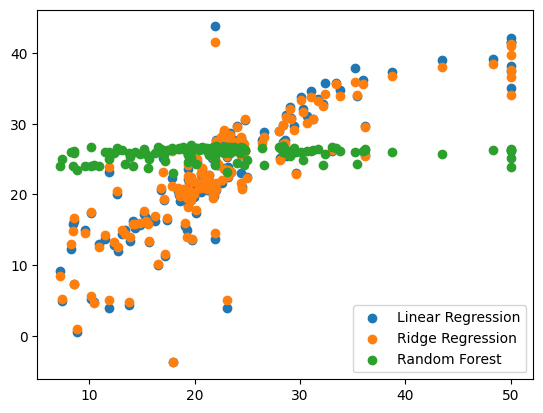

In [220]:
def least_square(X, y):
    #TODO
    # The Normal Equation
    theta = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
    return theta

def ridge_reg(X, y, eta):
    #TODO
    n,m = X.shape
    I = np.eye(m)
    theta = np.dot(np.linalg.inv(np.dot(X.T, X) + eta*I),np.dot(X.T,y))
    return theta

def pred_fn(X, theta):
    #TODO
    pred = np.dot(X, theta)
    return pred

#for linear regression on training and test datasets
theta_training = least_square(X_train, y_train)
pred_training = pred_fn(X_train,theta_training)
rmse_train = root_mean_square_error(pred_training,y_train)
print("RMSE for training data with linear regression: ", rmse_train)

pred_test = pred_fn(X_test, theta_training)
rmse_test = root_mean_square_error(pred_test,y_test)
print("RMSE for test data with linear regression: ", rmse_test)

#for ridge regression on training and test datasets
theta_training_ridge = ridge_reg(X_train, y_train, 25)
pred_training_ridge = pred_fn(X_train, theta_training_ridge)
pred_test_ridge = pred_fn(X_test, theta_training_ridge)
rmse_train_ridge = root_mean_square_error(pred_training_ridge, y_train)
print("RMSE for training data with ridge regression: ", rmse_train_ridge)
rmse_test_ridge = root_mean_square_error(pred_test_ridge, y_test)
print("RMSE for test data with ridge regression: ", rmse_test_ridge)

import matplotlib.pyplot as plt

# Plot the training data and predictions
#plt.subplots(figsize=(5,5))

plt.scatter(y_test,pred_test, label="Linear Regression")
plt.scatter( y_test,pred_test_ridge, label="Ridge Regression")
#plt.scatter(y_test,preds_gbdt,label ="GBDT")
plt.scatter(y_test,preds,label="Random Forest")
plt.legend()

Text(0.5, 1.0, 'Ridge Regression')

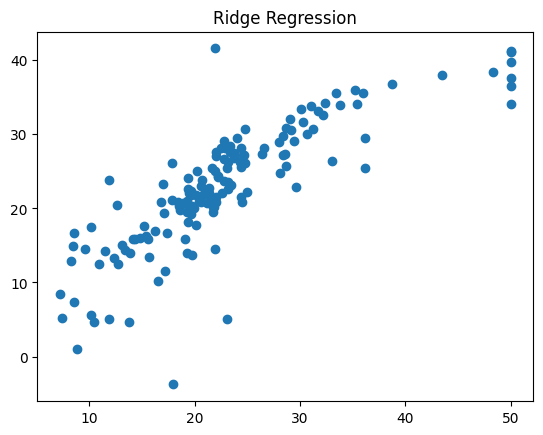

In [217]:
plt.scatter( y_test,pred_test_ridge, label="Ridge Regression")
plt.title('Ridge Regression')

In [221]:
# TODO: GBDT regression on boston house price dataset

# load data
from sklearn import datasets
boston = datasets.load_boston()
X = boston.data
y = boston.target

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

In [222]:
# TODO: GBDT classification on credit-g dataset

# load data
from sklearn.datasets import fetch_openml
X, y = fetch_openml('credit-g', version=1, return_X_y=True, data_home='credit/')
y = np.array(list(map(lambda x: 1 if x == 'good' else 0, y)))

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

In [223]:
# TODO: GBDT classification on breast cancer dataset

# load data
from sklearn import datasets
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)